In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re

import fastai
from nltk.stem import SnowballStemmer
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.svm import SVC


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I514609\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text_cleaning_regex = "@S+|https?:S+|http?:S|[^A-Za-z0-9]+"
stemmer = SnowballStemmer('english')

stop_words = stopwords.words('english')
print(stop_words)

tokenizer = Tokenizer()

In [104]:
df_train = pd.read_csv('train.csv')
print(df_train.head())
print(df_train.shape)

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
(7613, 5)


In [105]:
df_test = pd.read_csv('test.csv')
print(df_test.head())
print(df_test.shape)

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
(3263, 4)


In [106]:
# Check unbalanced target data
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:>

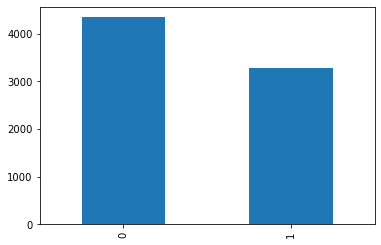

In [107]:
df_train['target'].value_counts().plot(kind='bar')

In [108]:
# Check missing data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [109]:
# Delete duplicate rows based on specific columns 
df_train = df_train.drop_duplicates(subset=["text"], keep='first')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


In [110]:
def clean_tweets(text, stem=False):
  # Text passed to the regex equatio
  text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stop_words:
      if stem:
        # Paased to the snowball stemmer
        tokens.append(stemmer.stem(token))
      else:
        # A
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [111]:
df_train.text = df_train.text.apply(lambda x: clean_tweets(x))
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation ord...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [112]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
df_train['word count'] = df_train['text'].apply(word_count)
df_train.head()

,id,keyword,location,text,target,word count
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,7
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7
2,5,NaN,NaN,residents asked shelter place notified officer...,1,11
3,6,NaN,NaN,13 000 people receive wildfires evacuation ord...,1,8
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,9


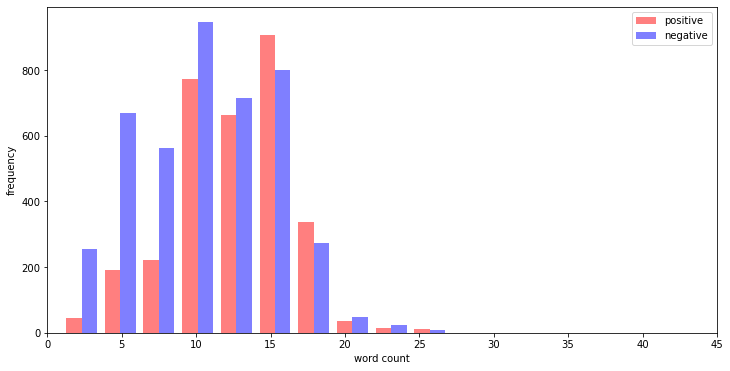

In [113]:
# plot word count distribution for both positive and negative sentiments
x = df_train['word count'][df_train.target == 1]
y = df_train['word count'][df_train.target == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [114]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(df_train['text'])

In [119]:
# Gradient Boosting Classifier
model_gradient_boosting = ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
model_gradient_boosting.fit(X_train, df_train.target)

GradientBoostingClassifier(max_depth=9, max_features=8, min_samples_leaf=2,
                           min_samples_split=6, n_estimators=2000,
                           subsample=0.9)

In [96]:
# SVC Classifier
model_svc = SVC(kernel='linear', C=1)
model_svc.fit(X_train, df_train.target)

SVC(C=1, kernel='linear')

In [117]:
# Clean test data
df_test.text = df_test.text.apply(lambda x: clean_tweets(x))
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan


In [120]:
# Gradient Boosting Classifier Prediction
result = model_gradient_boosting.predict(vectorizer.transform(df_test.text))
df_test['target'] = result
df_test[["id", "target"]].head()
df_test[["id", "target"]].to_csv('submission_gradient_boosting.csv', index=False)

In [98]:
# SVC Classifier Prediction
result = model_svc.predict(vectorizer.transform(df_test.text))
df_test['target'] = result
df_test[["id", "target"]].head()
df_test[["id", "target"]].to_csv('submission_svc.csv', index=False)